In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from linearmodels.panel import PanelOLS, compare, RandomEffects
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


## Bases de dados

In [2]:
df_empreend = pd.read_csv('../dados/tratados/simu_carteira_empreendimentos.csv')
df_agrup_munic_ano = pd.read_csv('../dados/tratados/agrupamento_empreend_acidentes_por_municipio_e_ano_sem_nulos.csv')

C:\Users\Richa\AppData\Local\Temp\ipykernel_22888\1350770001.py:1: DtypeWarning: Columns (9,42,61,78,79,93,95,97,101,102,105,115,116,117) have mixed types. Specify dtype option on import or set low_memory=False.
  df_empreend = pd.read_csv('../dados/tratados/simu_carteira_empreendimentos.csv')


In [3]:
print(df_agrup_munic_ano.columns.tolist())
df_agrup_munic_ano.head()

['Código IBGE', 'ano', 'vlr_investimento', 'pop_beneficiada', 'num_total_empreendimentos', 'aux_emp_implantacao', 'aux_emp_implantacao_vlr_investimento', 'aux_emp_pavimentacao', 'aux_emp_pavimentacao_vlr_investimento', 'aux_emp_refrota', 'aux_emp_refrota_vlr_investimento', 'aux_emp_sinalizacao', 'aux_emp_sinalizacao_vlr_investimento', 'aux_emp_calcamento', 'aux_emp_calcamento_vlr_investimento', 'aux_emp_ciclovia', 'aux_emp_ciclovia_vlr_investimento', 'aux_emp_corredor', 'aux_emp_corredor_vlr_investimento', 'aux_emp_drenagem', 'aux_emp_drenagem_vlr_investimento', 'aux_emp_ferrovia', 'aux_emp_ferrovia_vlr_investimento', 'aux_emp_transporte', 'aux_emp_transporte_vlr_investimento', 'aux_emp_brt', 'aux_emp_brt_vlr_investimento', 'aux_emp_vlt', 'aux_emp_vlt_vlr_investimento', 'aux_emp_qualificacao', 'aux_emp_qualificacao_vlr_investimento', 'aux_emp_mobilidade_urbana', 'aux_emp_mobilidade_urbana_vlr_investimento', 'aux_emp_aquisicao', 'aux_emp_aquisicao_vlr_investimento', 'aux_emp_polongament

,Código IBGE,ano,vlr_investimento,pop_beneficiada,num_total_empreendimentos,aux_emp_implantacao,aux_emp_implantacao_vlr_investimento,aux_emp_pavimentacao,aux_emp_pavimentacao_vlr_investimento,aux_emp_refrota,...,taxa_mun_motociclista_feridos,taxa_mun_automovel_feridos,taxa_mun_veiculo_pesado_feridos,taxa_mun_onibus_feridos,taxa_mun_outros_feridos,Populacao,taxa_mun_triciclo_mortes,taxa_mun_caminhonete_mortes,taxa_mun_triciclo_feridos,taxa_mun_caminhonete_feridos
0,1100015.0,2011.0,1530000.00,1841.0,2,0,0.0,2,1530000.00,0,...,0.000000,0.000000,0.0,0.000000,0.000000,24228.0,0.0,0.0,0.0,0.0
1,1100023.0,2012.0,1787781.82,2087.0,2,0,0.0,0,0.00,0,...,0.177903,0.002156,0.0,0.000000,0.000000,92747.0,0.0,0.0,0.0,0.0
2,1100023.0,2014.0,36842105.26,43512.0,1,0,0.0,1,36842105.26,0,...,0.055415,0.000000,0.0,0.000972,0.000000,102860.0,0.0,0.0,0.0,0.0
3,1100031.0,2011.0,265850.00,306.0,1,0,0.0,1,265850.00,0,...,0.000000,0.000000,0.0,0.000000,0.000000,6221.0,0.0,0.0,0.0,0.0
4,1100049.0,2010.0,2821324.40,3343.0,3,0,0.0,2,2290724.40,0,...,0.006363,0.000000,0.0,0.000000,0.001273,78574.0,0.0,0.0,0.0,0.0


## 

## Funções

In [4]:
def matrix_LI(matrix):
    """
    Identifica e retorna as colunas linearmente independentes de uma matriz.

    Parâmetros:
    ----------
    matrix : pd.DataFrame
        DataFrame contendo a matriz original cujas colunas serão avaliadas.

    Retornos:
    --------
    new_matrix : pd.DataFrame
        DataFrame contendo apenas as colunas linearmente independentes da matriz original.
    matrix_columns_selected : np.ndarray
        Array contendo os índices das colunas selecionadas que são linearmente independentes.
    """
    # Realiza a decomposição QR transposta da matriz
    _, R = np.linalg.qr(matrix.T)
    
    # Seleciona as colunas com valores absolutos dos elementos diagonais de R maiores que um limiar
    matrix_columns_selected = np.where(np.abs(R.diagonal()) > 1e-10)[0]
    
    # Cria uma nova matriz com as colunas selecionadas
    new_matrix = matrix.iloc[:, matrix_columns_selected]
    
    return new_matrix, matrix_columns_selected


In [5]:
def prepare_panel_data(df, selected_columns=[], check_rank=True):
    """
    Prepara os dados de um DataFrame para análise em painel.

    Parâmetros:
    ----------
    df : pd.DataFrame
        DataFrame contendo os dados a serem preparados.
    selected_columns : list, opcional
        Lista de colunas selecionadas para a análise. Se não fornecida, todas as colunas numéricas serão utilizadas.
    check_rank : bool, opcional
        Flag para indicar se a verificação do posto da matriz deve ser realizada.

    Retornos:
    --------
    df_panel : pd.DataFrame
        DataFrame preparado para análise em painel, com as colunas independentes, dependentes e eixos do painel selecionados.
    X : pd.DataFrame
        DataFrame contendo as variáveis independentes com uma constante adicionada.
    y1 : pd.Series
        Série contendo os valores da variável dependente 'total_mortes'.
    y2 : pd.Series
        Série contendo os valores da variável dependente 'total_feridos'.
    """

    # Fixos
    eixos_painel = ['Código IBGE', 'ano']
    y1_name = 'total_mortes'
    y2_name = 'total_feridos'

    if len(selected_columns) == 0:
        selected_columns = df.select_dtypes(include='number').columns.tolist()

    df_panel = df[pd.unique([y1_name, y2_name, *eixos_painel, *selected_columns]).tolist()].copy()
    df_panel['Código IBGE'] = df_panel['Código IBGE'].astype('category')
    df_panel.set_index(['Código IBGE', 'ano'], inplace=True)

    selected_columns = df_panel.columns
    x_columns_selected = selected_columns.drop([y1_name, y2_name]).tolist()

    X = df_panel[x_columns_selected]

    # Resolver problema de posto da matriz
    if check_rank:
        X_old = X.loc[:, (X != 0).any(axis=0)]
        X, _ = matrix_LI(X_old)
        selected_columns = [y1_name, y2_name, *X.columns.tolist()]
        df_panel = df_panel[selected_columns]

    X = sm.add_constant(X).astype(float)
    y1 = df_panel[y1_name].astype(float)
    y2 = df_panel[y2_name].astype(float)

    return df_panel, X, y1, y2

In [6]:
def fit_panel_data_model(X, y, show_summary=True):
    """
    Ajusta um modelo de dados em painel usando o método de Mínimos Quadrados Ordinários (OLS).

    Parâmetros:
    ----------
    X : pd.DataFrame
        DataFrame contendo as variáveis independentes.
    y : pd.Series
        Série contendo a variável dependente.
    show_summary : bool, opcional
        Flag para indicar se o resumo do modelo deve ser exibido. O padrão é True.

    Retornos:
    --------
    model : PanelOLS
        Modelo ajustado de dados em painel.
    """
    # Cria e ajusta o modelo de dados em painel com efeitos fixos para entidades
    model = PanelOLS(y, X, entity_effects=True)
    model = model.fit()
    
    # Exibe o resumo do modelo, se solicitado
    if show_summary:
        display(model.summary)
    
    return model



In [21]:
def teste_BP(X, y, y_name):
    """
    Realiza o teste de Breusch-Pagan para heterocedasticidade em um modelo de regressão OLS.

    Parâmetros:
    ----------
    X : pd.DataFrame
        DataFrame contendo as variáveis independentes.
    y : pd.Series
        Série contendo a variável dependente.
    y_name : str
        Nome da variável dependente para ser exibido nos títulos dos resultados.

    """
    # Ajusta um modelo de regressão OLS
    model_ols = sm.OLS(y, X).fit()
    
    # Realiza o teste de Breusch-Pagan para verificar a heterocedasticidade dos resíduos
    LM, LM_pv, F, F_pv = het_breuschpagan(model_ols.resid, model_ols.model.exog)
    
    # Labels para os resultados do teste
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    
    # Exibe os resultados do teste
    print(f"\n\nBreusch-Pagan Test for Total {y_name}:")
    print(dict(zip(labels, (LM, LM_pv, F, F_pv))))
    
    # Verifica a hipótese de homoscedasticidade
    print(f"\nHipótese de Homoscedasticidade: {'Não' if ((LM_pv > .05) and (F_pv > .05)) else ''} Rejeitada")


In [7]:
def plot_residuos(model, y_name):
    """
    Plota a distribuição dos resíduos e a relação entre resíduos e valores ajustados para um modelo de regressão.

    Parâmetros:
    ----------
    model : PanelOLS
        Modelo de dados em painel ajustado.
    y_name : str
        Nome da variável dependente para ser exibido nos títulos dos gráficos.

    """
    # Plota a distribuição dos resíduos
    plt.hist(model.resids, bins=50, edgecolor='k')
    plt.title(f'Distribuição dos Resíduos - {y_name}')
    plt.xlabel('Resíduos')
    plt.ylabel('Frequência')
    plt.show()

    # Plota os resíduos versus os valores ajustados
    plt.scatter(model.fitted_values, model.resids, alpha=0.5)
    plt.title(f'Resíduos vs Valores Ajustados - {y_name}')
    plt.xlabel('Valores Ajustados')
    plt.ylabel('Resíduos')
    plt.show()


In [8]:
def effect_by_year(df, model, show_resid_graph=True):
    """
    Avalia o efeito dos resíduos do modelo ao longo dos anos e realiza o teste de Breusch-Pagan para cada ano.

    Parâmetros:
    ----------
    df : pd.DataFrame
        DataFrame contendo os dados originais.
    model : PanelOLS
        Modelo de dados em painel ajustado.
    show_resid_graph : bool, opcional
        Flag para indicar se o gráfico dos resíduos médios ao longo do tempo deve ser exibido. O padrão é True.

    """
    df_aux = df.copy()
    
    # Adiciona os resíduos do modelo ao DataFrame auxiliar
    df_aux = df_aux.merge(model.resids, how='left', on=['Código IBGE', 'ano']).reset_index()
    df_aux.rename(columns={'residual': 'residuos'}, inplace=True)

    if show_resid_graph:
        # Calcula os resíduos médios por ano e por município
        residuos_por_ano = df_aux.groupby('ano')['residuos'].mean()
        residuos_por_municipio = df_aux.groupby('Código IBGE')['residuos'].mean()

        # Plota os resíduos médios ao longo do tempo
        plt.figure(figsize=(10, 6))
        plt.plot(residuos_por_ano, 'o-')
        plt.title('Resíduos Médios ao Longo do Tempo')
        plt.xlabel('Ano')
        plt.ylabel('Resíduos Médios')
        plt.show()

    # Realiza o teste de Breusch-Pagan para cada ano
    bp_results_ano = {}
    for year in df_aux['ano'].unique():
        df_year = df_aux[df_aux['ano'] == year]
        exog_year = df_year[df_year.columns.drop(['total_feridos', 'total_mortes'])]
        exog_year = sm.add_constant(exog_year)  # Adiciona uma constante
        _, lm_pvalue, _, f_pvalue = het_breuschpagan(df_year['residuos'], exog_year)
        bp_results_ano[year] = {'LM p-value': lm_pvalue, 'F p-value': f_pvalue}

    # Converte os resultados do teste de Breusch-Pagan para um DataFrame e exibe
    bp_results_ano_df = pd.DataFrame(bp_results_ano).T
    display(bp_results_ano_df)


In [9]:
def effect_by_city(df, model):
    """
    Avalia o efeito dos resíduos do modelo por município e realiza o teste de Breusch-Pagan para cada município.

    Parâmetros:
    ----------
    df : pd.DataFrame
        DataFrame contendo os dados originais.
    model : PanelOLS
        Modelo de dados em painel ajustado.

    """
    # Cria um DataFrame auxiliar e adiciona os resíduos do modelo
    df_aux = df.copy().merge(model.resids, how='left', on=['Código IBGE', 'ano']).reset_index()
    df_aux.rename(columns={'residual': 'residuos'}, inplace=True)
    
    # Realiza o teste de Breusch-Pagan para cada município
    bp_results_municipio = {}
    for municipio in df_aux['Código IBGE'].unique():
        df_municipio = df_aux[df_aux['Código IBGE'] == municipio]
        if len(df_municipio) > 1:  # Certifica-se de que há mais de uma observação por município
            exog_municipio = df_municipio[df_municipio.columns.drop(['total_feridos', 'total_mortes'])]
            exog_municipio = sm.add_constant(exog_municipio)  # Adiciona uma constante
            _, lm_pvalue, _, f_pvalue = het_breuschpagan(df_municipio['residuos'], exog_municipio)
            bp_results_municipio[municipio] = {'LM p-value': lm_pvalue, 'F p-value': f_pvalue}

    # Converte os resultados do teste de Breusch-Pagan para um DataFrame e exibe a descrição estatística
    bp_results_municipio_df = pd.DataFrame(bp_results_municipio).T
    print(bp_results_municipio_df.describe())




In [10]:
# Calcular o VIF para cada variável independente
def VIF(X):
    X_vif = sm.add_constant(X)  # Adicionar constante
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    return vif_data

In [11]:
def compare_random_fixed_panel(X, y):
    """
    Compara os modelos de efeitos fixos e aleatórios para um conjunto de dados em painel.

    Parâmetros:
    ----------
    X : pd.DataFrame
        DataFrame contendo as variáveis independentes.
    y : pd.Series
        Série contendo a variável dependente.

    """
    # Ajusta o modelo de efeitos fixos
    fe_model = PanelOLS(y, X, entity_effects=True).fit()
    
    # Ajusta o modelo de efeitos aleatórios
    re_model = RandomEffects(y, X).fit()
    
    # Compara os dois modelos
    comparison = compare({'Fixed Effects': fe_model, 'Random Effects': re_model})
    
    # Exibe a comparação dos modelos
    display(comparison)


In [12]:
def fit_random_effect(X, y, show_summary=True):
    # Modelo de Efeitos Aleatórios para Mortes
    fitted_model = RandomEffects(y, X).fit()
    if show_summary:
        fitted_model.summary
    return fitted_model

## Seleciona variáveis para os dados em painel

**Eixos:**

eixo transversal = $Município$

eixo temporal = $ano$

**Variáveis dependentes:**

$y_1=total\_mortes$

$y_2=total\_feridos$

**Variáveis independentes:**

$X =$ variáveis numéricas excluindo colunas que tornam a matriz LD

Variáveis explicativas escolhidas, a princípio,  de forma arbitrária:

In [15]:
df_panel, X, y_mortes, y_feridos = prepare_panel_data(df_agrup_munic_ano.copy())
X

const  vlr_investimento  pop_beneficiada  \
Código IBGE ano                                                
1100015.0   2011.0    1.0        1530000.00           1841.0   
1100023.0   2012.0    1.0        1787781.82           2087.0   
            2014.0    1.0       36842105.26          43512.0   
1100031.0   2011.0    1.0         265850.00            306.0   
1100049.0   2010.0    1.0        2821324.40           3343.0   
...                   ...               ...              ...   
5300108.0   2015.0    1.0       17026772.18          20665.0   
            2016.0    1.0        2988382.00           3678.0   
            2017.0    1.0        4525573.44           5614.0   
            2018.0    1.0       44260305.94          50705.0   
            2019.0    1.0        1020756.76           1268.0   

                    num_total_empreendimentos  aux_emp_implantacao  \
Código IBGE ano                                                      
1100015.0   2011.0                        2.0                  0.0   
1100023.0   2012.0                        2.0                  0.0   
            2014.0                        1.0                  0.0   
1100031.0   2011.0                        1.0                  0.0   
1100049.0   2010.0                        3.0                  0.0   
...                                       ...                  ...   
5300108.0   2015.0                        7.0                  1.0   
            2016.0                        3.0                  0.0   
            2017.0                        5.0                  2.0   
            2018.0                        8.0                  2.0   
            2019.0                        1.0                  0.0   

                    aux_emp_implantacao_vlr_investimento  \
Código IBGE ano                                            
1100015.0   2011.0                                  0.00   
1100023.0   2012.0                                  0.00   
            2014.0                                  0.00   
1100031.0   2011.0                                  0.00   
1100049.0   2010.0                                  0.00   
...                                                  ...   
5300108.0   2015.0                            2745666.67   
            2016.0                                  0.00   
            2017.0                            2407189.26   
            2018.0                           38486221.13   
            2019.0                                  0.00   

                    aux_emp_pavimentacao  \
Código IBGE ano                            
1100015.0   2011.0                   2.0   
1100023.0   2012.0                   0.0   
            2014.0                   1.0   
1100031.0   2011.0                   1.0   
1100049.0   2010.0                   2.0   
...                                  ...   
5300108.0   2015.0                   3.0   
            2016.0                   3.0   
            2017.0                   1.0   
            2018.0                   3.0   
            2019.0                   1.0   

                    aux_emp_pavimentacao_vlr_investimento  aux_emp_refrota  \
Código IBGE ano                                                              
1100015.0   2011.0                             1530000.00              0.0   
1100023.0   2012.0                                   0.00              0.0   
            2014.0                            36842105.26              0.0   
1100031.0   2011.0                              265850.00              0.0   
1100049.0   2010.0                             2290724.40              0.0   
...                                                   ...              ...   
5300108.0   2015.0                             2785984.00              0.0   
            2016.0                             2988382.00              0.0   
            2017.0                              988588.59              0.0   
            2018.0                             3725213.98       

## Efeitos Fixos

**Modelo simplificado**

$$y_{it} = \gamma_t + \beta'x_{it} + \epsilon_{it}$$

$$i = Município, \quad t = ano$$

https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.model.PanelOLS.html


In [17]:
model_mortes = fit_panel_data_model(X, y_mortes)


c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
 

Dep. Variable:,total_mortes,R-squared:,0.8903
Estimator:,PanelOLS,R-squared (Between):,0.5854
No. Observations:,20700,R-squared (Within):,0.8903
Date:,"Mon, Jun 03 2024",R-squared (Overall):,0.6481
Time:,21:44:42,Log-likelihood,-6.087e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1579.6
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(79,15377)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,1579.6


In [19]:
model_feridos = fit_panel_data_model(X, y_feridos)

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
 

Dep. Variable:,total_feridos,R-squared:,0.2458
Estimator:,PanelOLS,R-squared (Between):,0.2880
No. Observations:,20700,R-squared (Within):,0.2458
Date:,"Mon, Jun 03 2024",R-squared (Overall):,0.3382
Time:,21:44:46,Log-likelihood,-1.193e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,63.421
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(79,15377)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,63.421


### Resíduos

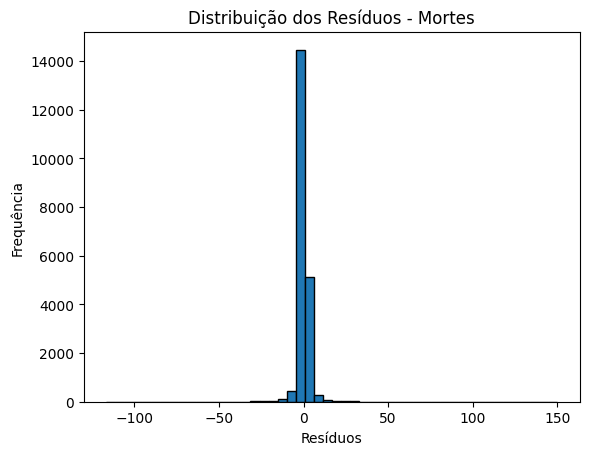

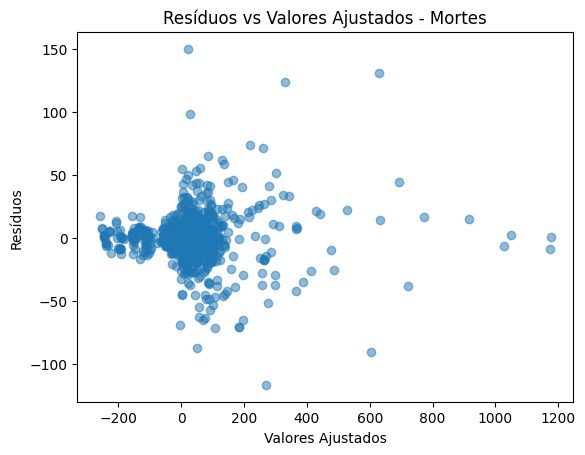

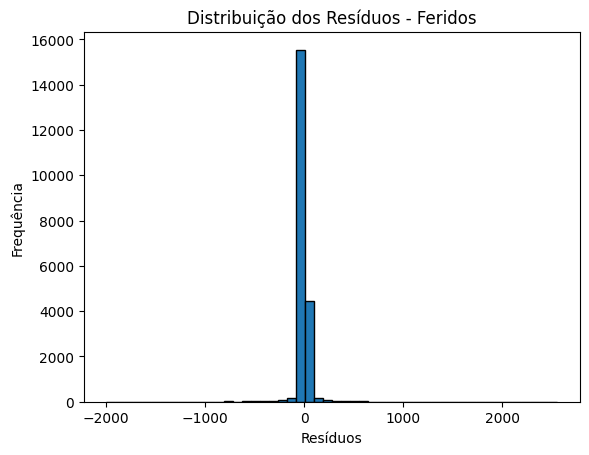

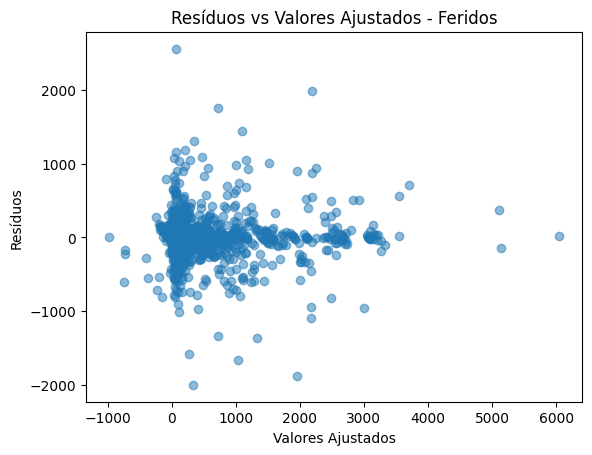

In [20]:
plot_residuos(model_mortes, 'Mortes')

plot_residuos(model_feridos, 'Feridos')

#### Teste de Breusch-Pagan para heteroscedasticidade

$H_0: Homoscedástico$

In [22]:
teste_BP(X, y_mortes, 'Mortes')
teste_BP(X, y_feridos, 'Feridos')



Breusch-Pagan Test for Total Mortes:
{'LM Statistic': 3496.6051336115593, 'LM-Test p-value': 0.0, 'F-Statistic': 53.0510522943481, 'F-Test p-value': 0.0}

Hipótese de Homoscedasticidade:  Rejeitada


Breusch-Pagan Test for Total Feridos:
{'LM Statistic': 4888.3169549164695, 'LM-Test p-value': 0.0, 'F-Statistic': 80.6942941510416, 'F-Test p-value': 0.0}

Hipótese de Homoscedasticidade:  Rejeitada


### Resíduos por efeito de munícipio ou ano 

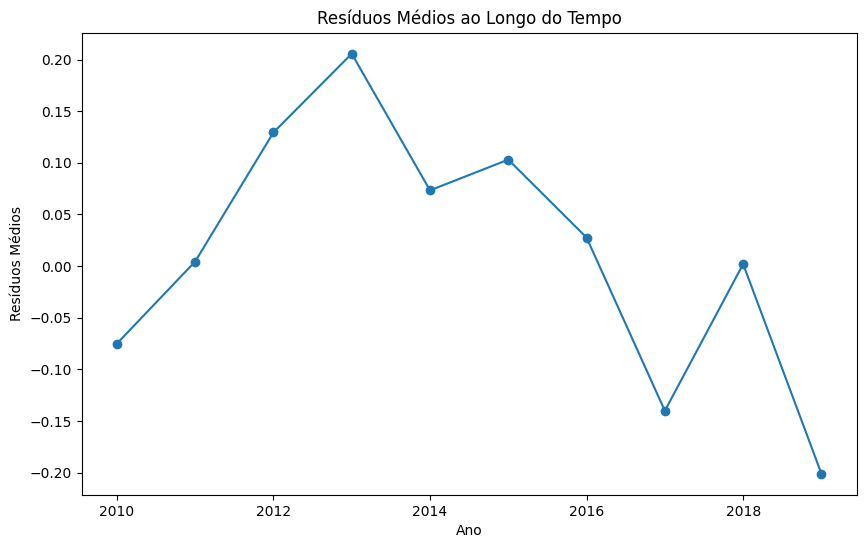

,LM p-value,F p-value
2011.0,1.054471e-175,0.000000e+00
2012.0,1.904220e-162,0.000000e+00
2014.0,0.000000e+00,0.000000e+00
2010.0,3.011254e-233,0.000000e+00
2013.0,2.163368e-227,0.000000e+00
2019.0,1.432059e-107,1.162960e-145
2015.0,9.443421e-103,4.057287e-146
2016.0,1.175630e-215,0.000000e+00
2017.0,0.000000e+00,0.000000e+00
2018.0,4.522074e-264,0.000000e+00


In [23]:
effect_by_year(df_panel, model_mortes)

In [26]:
# effect_by_city(df_panel, model_mortes)

       LM p-value  F p-value
count      4587.0        0.0
mean          1.0        NaN
std           0.0        NaN
min           1.0        NaN
25%           1.0        NaN
50%           1.0        NaN
75%           1.0        NaN
max           1.0        NaN


### Regressão Quantilica

In [27]:
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg

# Modelo de Regressão Quantílica para Mortes
quantile_model_mortes = QuantReg(y_mortes, X).fit(q=0.5)
quantile_model_mortes.summary()



c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\statsmodels\regression\linear_model.py:1967: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\statsmodels\regression\linear_model.py:1885: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:           total_mortes   Pseudo R-squared:               0.1338
Model:                       QuantReg   Bandwidth:                      0.6904
Method:                 Least Squares   Sparsity:                        6.628
Date:                Mon, 03 Jun 2024   No. Observations:                20700
Time:                        21:48:33   Df Residuals:                    20620
                                        Df Model:                           79
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                       4.796e-10        nan        nan        nan         nan         nan
vlr_investimento                            3.864e-06   4.53e-08     85.390      0.000    3.78e-06    3.95e-06
pop_beneficiada                                0.0001   4.31e-06     29.379      0.000       0.000       0.000
num_total_empreendimentos                   2.057e-09   5.87e-05    3.5e-05      1.000      -0.000       0.000
aux_emp_implantacao                         4.863e-10   8.05e-06   6.04e-05      1.000   -1.58e-05    1.58e-05
aux_emp_implantacao_vlr_investimento       -4.251e-07   1.66e-09   -256.355      0.000   -4.28e-07   -4.22e-07
aux_emp_pavimentacao                        1.222e-09   5.51e-05   2.22e-05      1.000      -0.000       0.000
aux_emp_pavimentacao_vlr_investimento       7.523e-07   6.06e-09    124.214      0.000     7.4e-07    7.64e-07
aux_emp_refrota                            -2.451e-11   5.61e-07  -4.37e-05      1.000    -1.1e-06     1.1e-06
aux_emp_refrota_vlr_investimento           -4.091e-06   5.93e-08    -69.035      0.000   -4.21e-06   -3.97e-06
aux_emp_sinalizacao                        -1.757e-10        nan        nan        nan         nan         nan
aux_emp_sinalizacao_vlr_investimento       -4.818e-09   1.78e-08     -0.271      0.787   -3.97e-08    3.01e-08
aux_emp_calcamento                          4.694e-11        nan        nan        nan         nan         nan
aux_emp_calcamento_vlr_investimento         7.762e-07   1.06e-07      7.292      0.000    5.68e-07    9.85e-07
aux_emp_ciclovia                            2.938e-10   8.27e-07      0.000      1.000   -1.62e-06    1.62e-06
aux_emp_ciclovia_vlr_investimento          -6.633e-07   1.33e-08    -49.951      0.000   -6.89e-07   -6.37e-07
aux_emp_corredor                            3.224e-10   2.79e-06      0.000      1.000   -5.46e-06    5.46e-06
aux_emp_corredor_vlr_investimento           1.047e-07   2.22e-09     47.064      0.000       1e-07    1.09e-07
aux_emp_drenagem                           -2.892e-10   3.45e-05  -8.37e-06      1.000   -6.77e-05    6.77e-05
aux_emp_drenagem_vlr_investimento          -7.913e-07   8.55e-09    -92.537      0.000   -8.08e-07   -7.75e-07
aux_emp_ferrovia                           -4.535e-12   1.94e-07  -2.34e-05      1.000    -3.8e-07     3.8e-07
aux_emp_ferrovia_vlr_investimento           2.183e-07   2.24e-09     97.675      0.000    2.14e-07    2.23e-07
aux_emp_transporte                          4.169e-10   4.21e-07      0.001      0.999   -8.24e-07    8.25e-07
aux_emp_transporte_vlr_investimento         1.428e-07   1.98e-09     71.996      0.000    1.39e-07    1.47e-07
aux_emp_brt                                 1.055e-11    1.3e-06    8.1e-06      1.000   -2.55e-06    2.55e-06
aux_emp_brt_vlr_investimento               -7.246e-08   2.47e-09    -29.376      0.000   -7.73e-08   -6.76e-08
aux_emp_vlt                                -1.292e-11   4.51e-07  -2.87e-05      1.000   -8.83e-07   

In [28]:
# Modelo de Regressão Quantílica para Feridos
quantile_model_feridos = QuantReg(y_feridos, X).fit(q=0.5)
quantile_model_feridos.summary()

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\statsmodels\regression\linear_model.py:1967: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\statsmodels\regression\linear_model.py:1885: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:          total_feridos   Pseudo R-squared:               0.1009
Model:                       QuantReg   Bandwidth:                     0.09486
Method:                 Least Squares   Sparsity:                       0.4210
Date:                Mon, 03 Jun 2024   No. Observations:                20700
Time:                        21:48:54   Df Residuals:                    20620
                                        Df Model:                           79
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                      -2.013e-06        nan        nan        nan         nan         nan
vlr_investimento                            1.172e-06   2.87e-09    407.724      0.000    1.17e-06    1.18e-06
pop_beneficiada                                0.0008   2.74e-07   3021.408      0.000       0.001       0.001
num_total_empreendimentos                  -2.451e-06   3.73e-06     -0.657      0.511   -9.76e-06    4.86e-06
aux_emp_implantacao                        -8.654e-08   5.11e-07     -0.169      0.866   -1.09e-06    9.16e-07
aux_emp_implantacao_vlr_investimento       -8.904e-07   1.05e-10  -8452.531      0.000   -8.91e-07    -8.9e-07
aux_emp_pavimentacao                       -1.942e-06    3.5e-06     -0.554      0.579   -8.81e-06    4.92e-06
aux_emp_pavimentacao_vlr_investimento      -1.532e-06   3.85e-10  -3982.115      0.000   -1.53e-06   -1.53e-06
aux_emp_refrota                              -4.6e-09   3.56e-08     -0.129      0.897   -7.44e-08    6.52e-08
aux_emp_refrota_vlr_investimento            5.976e-05   3.76e-09   1.59e+04      0.000    5.98e-05    5.98e-05
aux_emp_sinalizacao                          4.79e-08        nan        nan        nan         nan         nan
aux_emp_sinalizacao_vlr_investimento        1.216e-06   1.13e-09   1075.740      0.000    1.21e-06    1.22e-06
aux_emp_calcamento                          9.522e-09        nan        nan        nan         nan         nan
aux_emp_calcamento_vlr_investimento        -5.446e-07   6.76e-09    -80.539      0.000   -5.58e-07   -5.31e-07
aux_emp_ciclovia                            6.586e-09   5.25e-08      0.125      0.900   -9.64e-08     1.1e-07
aux_emp_ciclovia_vlr_investimento          -4.166e-06   8.44e-10  -4938.634      0.000   -4.17e-06   -4.16e-06
aux_emp_corredor                            1.438e-09   1.77e-07      0.008      0.994   -3.45e-07    3.48e-07
aux_emp_corredor_vlr_investimento           5.294e-08   1.41e-10    374.752      0.000    5.27e-08    5.32e-08
aux_emp_drenagem                           -2.744e-07   2.19e-06     -0.125      0.900   -4.57e-06    4.03e-06
aux_emp_drenagem_vlr_investimento           2.057e-08   5.43e-10     37.875      0.000    1.95e-08    2.16e-08
aux_emp_ferrovia                            1.108e-09   1.23e-08      0.090      0.928    -2.3e-08    2.52e-08
aux_emp_ferrovia_vlr_investimento           3.657e-06   1.42e-10   2.58e+04      0.000    3.66e-06    3.66e-06
aux_emp_transporte                         -3.562e-09   2.67e-08     -0.133      0.894    -5.6e-08    4.88e-08
aux_emp_transporte_vlr_investimento         2.177e-06   1.26e-10   1.73e+04      0.000    2.18e-06    2.18e-06
aux_emp_brt                                -7.412e-10   8.27e-08     -0.009      0.993   -1.63e-07    1.61e-07
aux_emp_brt_vlr_investimento                3.057e-07   1.57e-10   1951.173      0.000    3.05e-07    3.06e-07
aux_emp_vlt                                -1.154e-10   2.86e-08     -0.004      0.997   -5.62e-08   

Como o print apontou, há indícios de multicolinearidade ou outras questões atrapalhando as métricas

### VIF - correlação agrupada

Medida que verifica o grau de multicolinearidade em cada variável.

A estratégia é detectar variáveis com VIF muito grande (por exemplo >10) e eliminá-las do modelo

In [29]:
VIF(X)

,feature,VIF
0,const,4.270321
1,vlr_investimento,147787.172463
2,pop_beneficiada,823.787829
3,num_total_empreendimentos,1201.625542
4,aux_emp_implantacao,1.167776
...,...,...
75,Ocup_triciclo_motor_mortes,1.071964
76,Ocup_automovel_mortes,3.120446
77,Ocup_veic_transp_pesado_mortes,1.453048
78,taxa_mun_mortes,1.077802


## Efeitos Aleatórios

**Modelo simplificado**

$$y_{it} = \beta'x_{it} + u_i + \epsilon_{it}$$

$$i = Município, \quad t = ano$$

https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.model.RandomEffects.html

In [30]:
fit_random_effect(X, y_mortes, show_summary=True)

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sum_weights: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future ve

Dep. Variable:,total_mortes,R-squared:,0.9065
Estimator:,RandomEffects,R-squared (Between):,0.9346
No. Observations:,20700,R-squared (Within):,0.8598
Date:,"Mon, Jun 03 2024",R-squared (Overall):,0.9332
Time:,21:49:17,Log-likelihood,-6.915e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,2529.6
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(79,20620)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,2558.6


In [31]:
fit_random_effect(X, y_feridos, show_summary=True)

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sum_weights: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future ve

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:641: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  out = self._frame.groupby(level=level).count()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:641: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  out = self._frame.groupby(level

Dep. Variable:,total_feridos,R-squared:,0.5418
Estimator:,RandomEffects,R-squared (Between):,0.7261
No. Observations:,20700,R-squared (Within):,-0.1034
Date:,"Mon, Jun 03 2024",R-squared (Overall):,0.7061
Time:,21:49:21,Log-likelihood,-1.295e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,308.58
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(79,20620)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,311.58


### Teste de Hausman

$H_0: $ os interceptos de cada $i$ não são correlacionados com $X_{it}$

a estratégia é que, se rejeitar $H_0$, então o modelo de efeitos fixos é mais adequado

In [32]:
compare_random_fixed_panel(X, y_mortes)

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
 

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sum_weights: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future ve

,Fixed Effects,Random Effects
Dep. Variable,total_mortes,total_mortes
Estimator,PanelOLS,RandomEffects
No. Observations,20700,20700
Cov. Est.,Unadjusted,Unadjusted
R-squared,0.8903,0.9065
R-Squared (Within),0.8903,0.8598
R-Squared (Between),0.5854,0.9346
R-Squared (Overall),0.6481,0.9332
F-statistic,1579.6,2529.6
P-value (F-stat),0.0000,0.0000


In [33]:
compare_random_fixed_panel(X, y_feridos)


c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")


c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:641: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  out = self._frame.groupby(level=level).count()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=

,Fixed Effects,Random Effects
Dep. Variable,total_feridos,total_feridos
Estimator,PanelOLS,RandomEffects
No. Observations,20700,20700
Cov. Est.,Unadjusted,Unadjusted
R-squared,0.2458,0.5418
R-Squared (Within),0.2458,-0.1034
R-Squared (Between),0.2880,0.7261
R-Squared (Overall),0.3382,0.7061
F-statistic,63.421,308.58
P-value (F-stat),0.0000,0.0000


Com p-valor = 0 em ambos os testes (para mortos e feridos), é adequado usar o modelo de efeito fixos para os dois

## Próximos passos

Agrupar por grupos de municipios